In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Read in Data

In [2]:
links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
tags = pd.read_csv('./data/ml-latest-small/tags.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [21]:
movies = movies.join(pd.get_dummies(movies.genres.str.split('|').apply(pd.Series).stack()).sum(level=0))

In [23]:
movies.head(10)

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),Action|Crime|Thriller,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),Adventure|Children,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),Action,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),Action|Adventure|Thriller,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


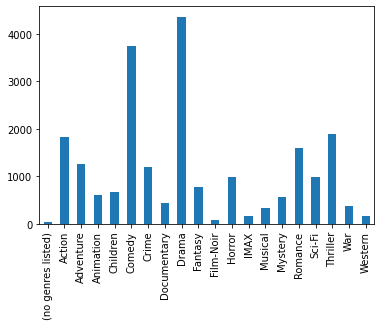

In [31]:
#distribution of grenres, high imbalance, will be much easier to guess drama, comedy, because of size, but also
# may not be specific enough to make quality reccomendations
# but if genre is small and rated highly easy to reccomend other movies in that genre
movies.loc[:,'(no genres listed)':].sum().plot(kind = 'bar')

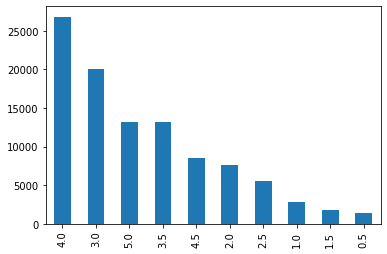

In [34]:
#most people rate >3.0 meaning that people tend to not give negative reviews, <2.5 
#could be a type of move to really avoid
ratings.rating.value_counts().plot(kind='bar')

In [101]:
movies['year'] = movies.title.str.extract(r'(\d{4})')

In [102]:
movies.year = np.where(movies.year.isnull() == True,1899,movies.year).astype(int)

conditions = [
    movies.year < 1880,
    movies.year > 2020
]

choices = [
    1890,
    1890
]

movies.year = np.select(conditions,choices, movies.year)

In [103]:
movies.year.value_counts().tail(10)

1900    2
1920    2
1921    1
1922    1
1915    1
1908    1
1917    1
1902    1
1903    1
1919    1
Name: year, dtype: int64

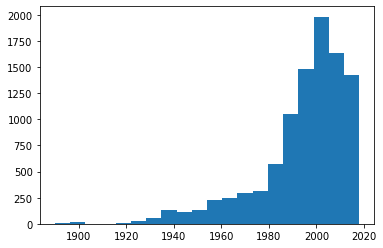

In [106]:
#distribution of movies releases
plt.hist(movies.year,bins = 20);